![MLU Logo](https://drive.corp.amazon.com/view/bwernes@/MLU_Logo.png?download=true)

# <a name="0">Machine Learning Accelerator - Tabular Data - Lecture 2</a>

## Tree-based Models 

### Sample Problem: Detecting Products with Electrical Plugs in Amazon Marketplace Products

In this notebook, we build, train, and tune by [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) a [Decision Tree Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) to predict the __target_label__ field (plug or no plug) of the Amazon electric plug dataset. 


1. <a href="#1">Read the datasets</a>
2. <a href="#2">Data Processing</a>
    * <a href="#21">Exploratory Data Analysis</a>
    * <a href="#22">Select features to build the model</a>
    * <a href="#23">Data Preprocessing (cleaning)</a>
    * <a href="#24">Train - Validation - Test Datasets</a>
    * <a href="#25">Data processing with Pipeline and ColumnTransformer</a>
3. <a href="#3">Train (and Tune) a Classifier</a>
4. <a href="#4">Test the Classifier</a>
5. <a href="#5">Improvement ideas</a>


__Dataset schema:__ 
- __ASIN__: Product ASIN
- __target_label:__ Binary field with values in {0,1}. A value of 1 show ASIN has a plug, otherwise 0.
- __ASIN_STATIC_ITEM_NAME:__ Title of the ASIN.
- __ASIN_STATIC_PRODUCT_DESCRIPTION:__ Description of the ASIN
- __ASIN_STATIC_GL_PRODUCT_GROUP_TYPE:__ GL information for the ASIN.
- __ASIN_STATIC_ITEM_PACKAGE_WEIGHT:__ Weight of the ASIN.
- __ASIN_STATIC_LIST_PRICE:__ Price information for the ASIN.
- __ASIN_STATIC_BATTERIES_INCLUDED:__ Information whether batteries are included along with the product.
- __ASIN_STATIC_BATTERIES_REQUIRED:__ Information whether batteries are required for using the product.
- __ASIN_STATIC_ITEM_CLASSIFICATION:__ Item classification of whether it is a standalone or bundle parent item etc


## 1. <a name="1">Read the datasets</a>
(<a href="#0">Go to top</a>)

Let's read the datasets into dataframes, using [Pandas](https://pandas.pydata.org/pandas-docs/stable/user_guide/10min.html).

In [1]:
import pandas as pd

import warnings
warnings.filterwarnings("ignore")
  
df = pd.read_csv('../../data/review/asin_electrical_plug_training_data.csv')
test_data = pd.read_csv('../../data/review/asin_electrical_plug_test_data.csv')

print('The shape of the training dataset is:', df.shape)
print('The shape of the test dataset is:', test_data.shape)

The shape of the training dataset is: (55109, 10)
The shape of the test dataset is: (6124, 10)


## 2. <a name="2">Data Processing</a>
(<a href="#0">Go to top</a>)

### 2.1 <a name="21">Exploratory Data Analysis</a>
(<a href="#2">Go to Data Processing</a>)

We look at number of rows, columns, and some simple statistics of the training dataset.

In [2]:
# Print the first five rows
# NaN means missing data
df.head()

,ASIN,target_label,ASIN_STATIC_ITEM_NAME,ASIN_STATIC_PRODUCT_DESCRIPTION,ASIN_STATIC_GL_PRODUCT_GROUP_TYPE,ASIN_STATIC_ITEM_PACKAGE_WEIGHT,ASIN_STATIC_LIST_PRICE,ASIN_STATIC_BATTERIES_INCLUDED,ASIN_STATIC_BATTERIES_REQUIRED,ASIN_STATIC_ITEM_CLASSIFICATION
0,B000816IUC,0,Bruder 02921 Jeep Wrangler Unlimited with Hors...,NEW! Jeep Wrangler by Bruder with trailer come...,gl_toy,3.450000,36.66,False,False,base_product
1,B003674A1Y,0,"Lucky Reptile OV-2 OpenAir Vivarium, Medium",Größe: 40x40x60 cm. <p>Lucky Reptile OpenAir V...,gl_pet_products,2.690000,24.68,False,False,base_product
2,B007ECONV4,0,"Klarfit KS5DG Chin Up Bar (150kg Max Load, Doo...",<p><b>Highly flexible pull-up bar with six con...,gl_sports,8.112928,NaN,False,False,base_product
3,B00D89465A,0,Liverpool FC Stripe Wallpaper,This fantastic Liverpool Wallpaper is ideal fo...,gl_home,1.763680,8.33,NaN,NaN,base_product
4,B001MJ0BN4,0,Rolson 68889 Oil Tanned Double Tool Pouch,"Eleven pockets, two fixed metal hammer holders...",gl_biss,2.733704,27.38,NaN,NaN,base_product


In [3]:
print('The shape of the dataset is:', df.shape)

The shape of the dataset is: (55109, 10)


In [4]:
# Let's see the data types and non-null values for each column
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 55109 entries, 0 to 55108
Data columns (total 10 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   ASIN                               55109 non-null  object 
 1   target_label                       55109 non-null  int64  
 2   ASIN_STATIC_ITEM_NAME              55109 non-null  object 
 3   ASIN_STATIC_PRODUCT_DESCRIPTION    31727 non-null  object 
 4   ASIN_STATIC_GL_PRODUCT_GROUP_TYPE  55109 non-null  object 
 5   ASIN_STATIC_ITEM_PACKAGE_WEIGHT    55027 non-null  float64
 6   ASIN_STATIC_LIST_PRICE             41182 non-null  float64
 7   ASIN_STATIC_BATTERIES_INCLUDED     45016 non-null  object 
 8   ASIN_STATIC_BATTERIES_REQUIRED     40688 non-null  object 
 9   ASIN_STATIC_ITEM_CLASSIFICATION    55097 non-null  object 
dtypes: float64(2), int64(1), object(7)
memory usage: 4.6+ MB


In [5]:
# This prints basic statistics for numerical columns
df.describe()

,target_label,ASIN_STATIC_ITEM_PACKAGE_WEIGHT,ASIN_STATIC_LIST_PRICE
count,55109.000000,55027.000000,4.118200e+04
mean,0.036618,31.130529,1.563334e+02
std,0.187825,458.771422,1.754345e+04
min,0.000000,0.000000,1.160000e+00
25%,0.000000,1.520000,1.667000e+01
50%,0.000000,2.513244,3.268500e+01
75%,0.000000,5.555592,6.999000e+01
max,1.000000,29500.000000,3.560000e+06


#### Target distribution

Let's check our target distribution.

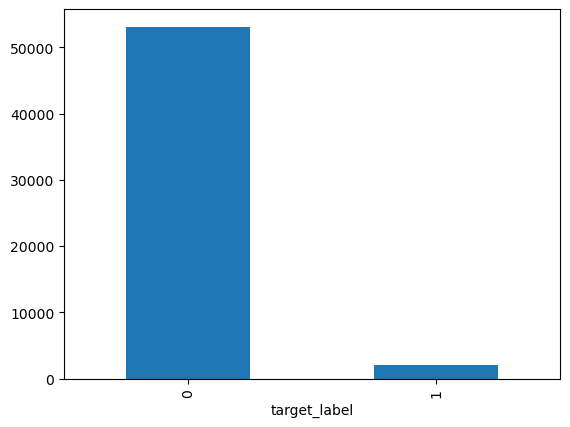

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

df['target_label'].value_counts().plot.bar()
plt.show()

We notice that we are dealing with an imbalanced dataset. This means one result type is dominating the other one(s). In this case, we have a lot of class 0 ("no plug") records and very few class 1 ("plug") records. 

#### Dataset features

Let's now print the features of our dataset.

In [7]:
import numpy as np                    
# use this for datasets with more columns, to print all columns
# (beware, if might raise memory errors when trying to print the text features values!)
# np.set_printoptions(threshold=np.inf) 

# This prints the column labels of the dataframe
print('All dataset columns:')
print(df.columns.values)

# This prints the column labels of the features identified as numerical
print('Numerical columns:')
print(df.select_dtypes(include=np.number).columns.values)

# This prints the column labels of the features identified as numerical
print('Categorical columns:')
print(df.select_dtypes(include='object').columns.values)

All dataset columns:
['ASIN' 'target_label' 'ASIN_STATIC_ITEM_NAME'
 'ASIN_STATIC_PRODUCT_DESCRIPTION' 'ASIN_STATIC_GL_PRODUCT_GROUP_TYPE'
 'ASIN_STATIC_ITEM_PACKAGE_WEIGHT' 'ASIN_STATIC_LIST_PRICE'
 'ASIN_STATIC_BATTERIES_INCLUDED' 'ASIN_STATIC_BATTERIES_REQUIRED'
 'ASIN_STATIC_ITEM_CLASSIFICATION']
Numerical columns:
['target_label' 'ASIN_STATIC_ITEM_PACKAGE_WEIGHT' 'ASIN_STATIC_LIST_PRICE']
Categorical columns:
['ASIN' 'ASIN_STATIC_ITEM_NAME' 'ASIN_STATIC_PRODUCT_DESCRIPTION'
 'ASIN_STATIC_GL_PRODUCT_GROUP_TYPE' 'ASIN_STATIC_BATTERIES_INCLUDED'
 'ASIN_STATIC_BATTERIES_REQUIRED' 'ASIN_STATIC_ITEM_CLASSIFICATION']


### 2.2 <a name="22">Select features to build the model</a>
(<a href="#2">Go to Data Processing</a>)

This time we build a model using all features (except __ASIN__). That is, we build a classifier including __numerical, categorical__ and __text__ features. 

In [8]:
# Grab model features/inputs and target/output
numerical_features = ["ASIN_STATIC_ITEM_PACKAGE_WEIGHT",
                      "ASIN_STATIC_LIST_PRICE"]

categorical_features = ['ASIN_STATIC_GL_PRODUCT_GROUP_TYPE',
               'ASIN_STATIC_BATTERIES_INCLUDED',
               'ASIN_STATIC_BATTERIES_REQUIRED',
               'ASIN_STATIC_ITEM_CLASSIFICATION']

text_features = ['ASIN_STATIC_ITEM_NAME',
                 'ASIN_STATIC_PRODUCT_DESCRIPTION']

model_features = numerical_features + categorical_features + text_features
model_target = 'target_label'


### 2.3 <a name="23">Data Preprocessing (Cleaning)</a>
(<a href="#2">Go to Data Processing</a>)

Before data processing, we first clean the dataset.


### Cleaning numerical features 

Let's examine the numerical features.

In [9]:
for i in range(0,len(numerical_features)):
    print(df[numerical_features[i]].value_counts(bins=10, sort=False))

ASIN_STATIC_ITEM_PACKAGE_WEIGHT
(-29.501, 2950.0]     54910
(2950.0, 5900.0]         50
(5900.0, 8850.0]         28
(8850.0, 11800.0]        19
(11800.0, 14750.0]        8
(14750.0, 17700.0]        7
(17700.0, 20650.0]        1
(20650.0, 23600.0]        0
(23600.0, 26550.0]        1
(26550.0, 29500.0]        3
Name: count, dtype: int64
ASIN_STATIC_LIST_PRICE
(-3558.84, 356001.044]              41181
(356001.044, 712000.9280000001]         0
(712000.9280000001, 1068000.812]        0
(1068000.812, 1424000.696]              0
(1424000.696, 1780000.58]               0
(1780000.58, 2136000.464]               0
(2136000.464, 2492000.348]              0
(2492000.348, 2848000.232]              0
(2848000.232, 3204000.116]              0
(3204000.116, 3560000.0]                1
Name: count, dtype: int64


__Outliers__. We have an outlier data in the last bin of the second numerical feature. We will remove this data point below.

In [10]:
#print(df[df[numerical_features[1]] > 3000000])
dropIndexes = df[df[numerical_features[1]] > 3000000].index
df.drop(dropIndexes , inplace=True)

In [11]:
df[numerical_features[1]].value_counts(bins=10, sort=False)

ASIN_STATIC_LIST_PRICE
(-13.839, 1500.944]                41147
(1500.944, 3000.728]                  15
(3000.728, 4500.512]                   8
(4500.512, 6000.296]                   3
(6000.296, 7500.08]                    2
(7500.08, 8999.864]                    3
(8999.864, 10499.648000000001]         0
(10499.648000000001, 11999.432]        1
(11999.432, 13499.216]                 0
(13499.216, 14999.0]                   2
Name: count, dtype: int64

__Missing Numerical Values__. Let's check missing values for these numerical features.

In [12]:
print(df[numerical_features].isna().sum())

ASIN_STATIC_ITEM_PACKAGE_WEIGHT       82
ASIN_STATIC_LIST_PRICE             13927
dtype: int64


As a quick fix, we will apply mean imputation. This will replace the missing values with the mean value of the corresponding column.

__Note on imputation__: The statistically correct way to perform mean/mode imputation before training an ML model is to compute the column-wise means on the training data only, and then use these values to impute missing data in the train, validation, and test sets. So, we'll need to split our training dataset first. Same goes for any other transformations we would like to apply to these numerical features, such as scaling or encoding. 

### Cleaning categorical features 

Let's also examine the categorical features.

In [13]:
for c in categorical_features:
    print(c)
    print(df[c].unique()) #value_counts())

ASIN_STATIC_GL_PRODUCT_GROUP_TYPE
['gl_toy' 'gl_pet_products' 'gl_sports' 'gl_home' 'gl_biss'
 'gl_home_improvement' 'gl_baby_product' 'gl_office_product'
 'gl_lawn_and_garden' 'gl_musical_instruments' 'gl_camera' 'gl_kitchen'
 'gl_automotive' 'gl_electronics' 'gl_personal_care_appliances' 'gl_pc'
 'gl_drugstore' 'gl_luggage' 'gl_wireless' 'gl_home_entertainment'
 'gl_major_appliances' 'gl_apparel' 'gl_beauty' 'gl_shoes' 'gl_watch'
 'gl_video_games' 'gl_book' 'gl_music' 'gl_fresh_ambient']
ASIN_STATIC_BATTERIES_INCLUDED
[False nan True]
ASIN_STATIC_BATTERIES_REQUIRED
[False nan True]
ASIN_STATIC_ITEM_CLASSIFICATION
['base_product' nan 'variation_parent']


__Note on boolean type__: Most categories are strings, except the __nan__s, and the booleans __False__ and __True__. The booleans will raise errors when trying to encode the categoricals with sklearn encoders, none of which accept boolean types. If using pandas get_dummies to one-hot encode the categoricals, there's no need to convert the booleans. However, get_dummies is trickier to use with sklearn's Pipeline and GridSearch. 

One way to deal with the booleans is to convert them to strings, by using a mask and a map changing only the booleans.

In [14]:
# Converting booleans to strings for a dataframe
def convert_bool_to_str(dataframe):
    mask = dataframe.applymap(type) != bool
    do = {True: 'TRUE', False: 'FALSE'}
    return dataframe.where(mask, dataframe.replace(do))

In [15]:
# Convert booleans to strings for training and test datasets
df_masked = convert_bool_to_str(df)
test_data_masked = convert_bool_to_str(test_data)

In [16]:
for c in categorical_features:
    print(c)
    print(df_masked[c].unique()) #value_counts())

ASIN_STATIC_GL_PRODUCT_GROUP_TYPE
['gl_toy' 'gl_pet_products' 'gl_sports' 'gl_home' 'gl_biss'
 'gl_home_improvement' 'gl_baby_product' 'gl_office_product'
 'gl_lawn_and_garden' 'gl_musical_instruments' 'gl_camera' 'gl_kitchen'
 'gl_automotive' 'gl_electronics' 'gl_personal_care_appliances' 'gl_pc'
 'gl_drugstore' 'gl_luggage' 'gl_wireless' 'gl_home_entertainment'
 'gl_major_appliances' 'gl_apparel' 'gl_beauty' 'gl_shoes' 'gl_watch'
 'gl_video_games' 'gl_book' 'gl_music' 'gl_fresh_ambient']
ASIN_STATIC_BATTERIES_INCLUDED
['FALSE' nan 'TRUE']
ASIN_STATIC_BATTERIES_REQUIRED
['FALSE' nan 'TRUE']
ASIN_STATIC_ITEM_CLASSIFICATION
['base_product' nan 'variation_parent']


Another way to handle the booleans is to convert them to strings by changing the type of all categoricals to 'str'. This will also affect the nans, basically performing imputation of the nans with a 'nans' placeholder value! 

Applying the type conversion to both categoricals and text features, takes care of the nans in the text fields as well. In case other imputations are planned for the categoricals and/or test fields, notice that the masking shown above leaves the nans unchanged.

In [17]:
# Perform boolean to string operation on training and test datasets
df[categorical_features + text_features] = df[categorical_features + text_features].astype('str')
test_data[categorical_features + text_features] = test_data[categorical_features + text_features].astype('str')

In [18]:
for c in categorical_features:
    print(c)
    print(df[c].unique()) #value_counts())

ASIN_STATIC_GL_PRODUCT_GROUP_TYPE
['gl_toy' 'gl_pet_products' 'gl_sports' 'gl_home' 'gl_biss'
 'gl_home_improvement' 'gl_baby_product' 'gl_office_product'
 'gl_lawn_and_garden' 'gl_musical_instruments' 'gl_camera' 'gl_kitchen'
 'gl_automotive' 'gl_electronics' 'gl_personal_care_appliances' 'gl_pc'
 'gl_drugstore' 'gl_luggage' 'gl_wireless' 'gl_home_entertainment'
 'gl_major_appliances' 'gl_apparel' 'gl_beauty' 'gl_shoes' 'gl_watch'
 'gl_video_games' 'gl_book' 'gl_music' 'gl_fresh_ambient']
ASIN_STATIC_BATTERIES_INCLUDED
['False' 'nan' 'True']
ASIN_STATIC_BATTERIES_REQUIRED
['False' 'nan' 'True']
ASIN_STATIC_ITEM_CLASSIFICATION
['base_product' 'nan' 'variation_parent']


Converting categoricals into useful numerical features, will also have to wait until after the train/test split.

### Cleaning text features 

Also a good idea to look at the text fields. Text cleaning can be performed here, before train/validation split, with less code.

In [19]:
for c in text_features:
    print(c)
    print(df[c].unique()) #value_counts())

ASIN_STATIC_ITEM_NAME
['Bruder 02921 Jeep Wrangler Unlimited with Horse Trailer incl. 1 Horse'
 'Lucky Reptile OV-2 OpenAir Vivarium, Medium'
 'Klarfit KS5DG Chin Up Bar (150kg Max Load, Door Mounted & Steel Frame) - Black'
 ...
 'Hama 00096150 file storage box/organizer - file storage boxes & organizers (177 x 225 x 185 mm)'
 'Vogels EFW 8125 MOTION S Wall Mount with Arm for 19 - 32-Inch LCD/Plasma TV'
 'Rexel Nyrex Slimview Display Book A4 Black (50 Pockets)']
ASIN_STATIC_PRODUCT_DESCRIPTION
['NEW! Jeep Wrangler by Bruder with trailer comes with a horse - which makes it a great gift for the equestrian in your family as well as for collectors of unique toys. This well designed combination urges children to use their imagination in constructive play. The horse trailer has a stabilizer leg, a side door that opens and is compatible with Pro Series Tractors and Unimogs. Dimensions: L650 x W140 x H190mm.'
 'Größe: 40x40x60 cm. <p>Lucky Reptile OpenAir Vivarium</p> <p>Das OpenAir Vivarium b

We re-use the helper functions from the 'Text processing' notebook.

In [20]:
# Prepare cleaning functions
import re, string
import nltk
from nltk.stem import SnowballStemmer

stop_words = ["a", "an", "the", "this", "that", "is", "it", "to", "and"]

stemmer = SnowballStemmer('english')

def preProcessText(text):
    # lowercase and strip leading/trailing white space
    text = text.lower().strip()
    
    # remove HTML tags
    text = re.compile('<.*?>').sub('', text)
    
    # remove punctuation
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)
    
    # remove extra white space
    text = re.sub('\s+', ' ', text)
    
    return text

def lexiconProcess(text, stop_words, stemmer):
    filtered_sentence = []
    words = text.split(" ")
    for w in words:
        if w not in stop_words:
            filtered_sentence.append(stemmer.stem(w))
    text = " ".join(filtered_sentence)
    
    return text

def cleanSentence(text, stop_words, stemmer):
    return lexiconProcess(preProcessText(text), stop_words, stemmer)


__Warning__: The text cleaning process can take a long time to complete, depending on the size of the text data!

In [21]:
# Clean the text features
for c in text_features:
    print('Text cleaning: ', c)
    df[c] = [cleanSentence(item, stop_words, stemmer) for item in df[c].values]
    test_data[c] = [cleanSentence(item, stop_words, stemmer) for item in test_data[c].values]

Text cleaning:  ASIN_STATIC_ITEM_NAME
Text cleaning:  ASIN_STATIC_PRODUCT_DESCRIPTION


The cleaned text features of the training and test dataset are ready to be vectorized.

### 2.4 <a name="24">Train - Validation - Test Datasets</a>
(<a href="#2">Go to Data Processing</a>)

We plan to use the k-fold cross-validation within the GridSearchCV and/or RandomizedSearchCV from sklearn, so we simply use the training (__df__) and test (__test_data__) datasets that we read from the data files. Train-test splits can be performed using sklearn's [train_test_split()](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) function.

In [22]:
# Set the training data as our df
train_data = df

# Print the shapes of the Train - Test Datasets
print('Train - Test Datasets shapes: ', train_data.shape, test_data.shape)

Train - Test Datasets shapes:  (55108, 10) (6124, 10)


### 2.5 <a name="25">Data processing with Pipeline and ColumnTransformer</a>
(<a href="#2">Go to Data Processing</a>)

Let's build a more complex pipeline today. We first build separate pipelines to handle the numerical, categorical, and text features, and then combine them into a composite pipeline along with an estimator, a [Decision Tree Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) here.

   * __Numerical features pipeline:__ See the __numerical_processor__ below. We impute missing values with the mean using sklearn's SimpleImputer, followed by a MinMaxScaler (don't have to scale features when using Decision Trees, but it's a good idea to see how to use more data transforms). If different processing is desired for different numerical features, different pipelines should be built - just like shown below for the two text features.
   
   
   * __Categoricals pipeline:__ See the __categorical_processor__ below. We impute with a placeholder value (no effect here as we already encoded the 'nan's), and encode with sklearn's OneHotEncoder. If computing memory is an issue, it is a good idea to check categoricals' unique values, to get an estimate of many dummy features will be created by one-hot encoding. Note the __handle_unknown__ parameter that tells the encoder to ignore (rather than throw an error for) any unique value that might show in the validation/and or test set that was not present in the initial training set.
  
   
   * __Text features pipeline:__ Finally, also with memory usage in mind, we build two more pipelines, one for each of our text features. The pipeline vectorizing __ASIN_STATIC_ITEM_NAME__, the __text_processor_0__ below, uses a vocabulary smaller in size than the pipeline vectorizing __ASIN_STATIC_PRODUCT_DESCRIPTION__, the __text_processor_1__ below. Current sklearn implementation requires a __separate transformer__ for __each text feature__ (unlike the numerical and categoricals).
   
   
The selective preparations of the dataset features are then put together into a collective 
__ColumnTransformer__, to be finally used in a Pipeline along with an estimator. This ensures that the transforms are performed automatically on the raw data when fitting the model and when making predictions, such as when evaluating the model on a validation dataset via cross-validation or making predictions on a test dataset in the future.

In [23]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

### COLUMN_TRANSFORMER ###
##########################

# Preprocess the numerical features
numerical_processor = Pipeline([
    ('num_imputer', SimpleImputer(strategy='mean')),
    ('num_scaler', MinMaxScaler()) # Shown in case is needed, not a must with Decision Trees
                                ])
                  
# Preprocess the categorical features
categorical_processor = Pipeline([
    ('cat_imputer', SimpleImputer(strategy='constant', fill_value='missing')), # Shown in case is needed, no effect here as we already imputed with 'nan' strings
    ('cat_encoder', OneHotEncoder(handle_unknown='ignore')) # handle_unknown tells it to ignore (rather than throw an error for) any value that was not present in the initial training set.
                                ])

# Preprocess 1st text feature
text_processor_0 = Pipeline([
    ('text_vectorizer_0', CountVectorizer(binary=True, max_features=50))
                                ])

# Preprocess 2nd text feature (larger vocabulary)
text_processor_1 = Pipeline([
    ('text_vectorizer_1', CountVectorizer(binary=True, max_features=150))
                                ])

# Combine all data preprocessors from above (add more, if you choose to define more!)
# For each processor/step specify: a name, the actual process, and finally the features to be processed
data_processor = ColumnTransformer([
    ('numerical_processing', numerical_processor, numerical_features),
    ('categorical_processing', categorical_processor, categorical_features),
    ('text_processing_0', text_processor_0, text_features[0]),
    ('text_processing_1', text_processor_1, text_features[1])
                                    ]) 

# Visualize the data processing pipeline
from sklearn import set_config
set_config(display='diagram')
data_processor


ColumnTransformer(transformers=[('numerical_processing',
                                 Pipeline(steps=[('num_imputer',
                                                  SimpleImputer()),
                                                 ('num_scaler',
                                                  MinMaxScaler())]),
                                 ['ASIN_STATIC_ITEM_PACKAGE_WEIGHT',
                                  'ASIN_STATIC_LIST_PRICE']),
                                ('categorical_processing',
                                 Pipeline(steps=[('cat_imputer',
                                                  SimpleImputer(fill_value='missing',
                                                                strategy='constant')),
                                                 ('cat_encoder',
                                                  OneHotEncoder(handle_un...
                                  'ASIN_STATIC_BATTERIES_INCLUDED',
                                  'ASIN_STATIC_BATTERIES_REQUIRED',
                                  'ASIN_STATIC_ITEM_CLASSIFICATION']),
                                ('text_processing_0',
                                 Pipeline(steps=[('text_vectorizer_0',
                                                  CountVectorizer(binary=True,
                                                                  max_features=50))]),
                                 'ASIN_STATIC_ITEM_NAME'),
                                ('text_processing_1',
                                 Pipeline(steps=[('text_vectorizer_1',
                                                  CountVectorizer(binary=True,
                                                                  max_features=150))]),
                                 'ASIN_STATIC_PRODUCT_DESCRIPTION')])

## 3. <a name="3">Train (and Tune) a Classifier</a>
(<a href="#0">Go to top</a>)

We use sklearn's [DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) to train a Decision Tree model. We pipeline the desired data transformers, along with a Decision Tree estimator.


In [24]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline

### PIPELINE ###
################

# Pipeline desired all data transformers, along with an estimator at the end
# Later you can set/reach the parameters using the names issued - for hyperparameter tuning, for example
pipeline = Pipeline([
    ('data_processing', data_processor),
    ('dt', DecisionTreeClassifier())
                    ])

# Visualize the pipeline
# This will come in handy especially when building more complex pipelines, stringing together multiple preprocessing steps
from sklearn import set_config
set_config(display='diagram')
pipeline


Pipeline(steps=[('data_processing',
                 ColumnTransformer(transformers=[('numerical_processing',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer()),
                                                                  ('num_scaler',
                                                                   MinMaxScaler())]),
                                                  ['ASIN_STATIC_ITEM_PACKAGE_WEIGHT',
                                                   'ASIN_STATIC_LIST_PRICE']),
                                                 ('categorical_processing',
                                                  Pipeline(steps=[('cat_imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('c...
                                                   'ASIN_STATIC_BATTERIES_REQUIRED',
                                                   'ASIN_STATIC_ITEM_CLASSIFICATION']),
                                                 ('text_processing_0',
                                                  Pipeline(steps=[('text_vectorizer_0',
                                                                   CountVectorizer(binary=True,
                                                                                   max_features=50))]),
                                                  'ASIN_STATIC_ITEM_NAME'),
                                                 ('text_processing_1',
                                                  Pipeline(steps=[('text_vectorizer_1',
                                                                   CountVectorizer(binary=True,
                                                                                   max_features=150))]),
                                                  'ASIN_STATIC_PRODUCT_DESCRIPTION')])),
                ('dt', DecisionTreeClassifier())])

### Model Training

We train the classifier with __.fit()__ on our training dataset. 

In [25]:
# Get train data to train the classifier
X_train = train_data[model_features]
y_train = train_data[model_target]

# Fit the classifier to the train data
# Train data going through the Pipeline it's imputed (with means from the train data), 
#   scaled (with the min/max from the train data), 
#   and finally used to fit the model
pipeline.fit(X_train, y_train)


Pipeline(steps=[('data_processing',
                 ColumnTransformer(transformers=[('numerical_processing',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer()),
                                                                  ('num_scaler',
                                                                   MinMaxScaler())]),
                                                  ['ASIN_STATIC_ITEM_PACKAGE_WEIGHT',
                                                   'ASIN_STATIC_LIST_PRICE']),
                                                 ('categorical_processing',
                                                  Pipeline(steps=[('cat_imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('c...
                                                   'ASIN_STATIC_BATTERIES_REQUIRED',
                                                   'ASIN_STATIC_ITEM_CLASSIFICATION']),
                                                 ('text_processing_0',
                                                  Pipeline(steps=[('text_vectorizer_0',
                                                                   CountVectorizer(binary=True,
                                                                                   max_features=50))]),
                                                  'ASIN_STATIC_ITEM_NAME'),
                                                 ('text_processing_1',
                                                  Pipeline(steps=[('text_vectorizer_1',
                                                                   CountVectorizer(binary=True,
                                                                                   max_features=150))]),
                                                  'ASIN_STATIC_PRODUCT_DESCRIPTION')])),
                ('dt', DecisionTreeClassifier())])

Let's now evaluate the performance of the trained classifier, on the training and the test datasets. We use __.predict()__ this time. 


In [26]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Use the fitted model to make predictions on the train dataset
# Train data going through the Pipeline it's imputed (with means from the train data), 
#   scaled (with the min/max from the train data), 
#   and finally used to make predictions
train_predictions = pipeline.predict(X_train)

print('Model performance on the train set:')
print(confusion_matrix(y_train, train_predictions))
print(classification_report(y_train, train_predictions))
print("Train accuracy:", accuracy_score(y_train, train_predictions))

Model performance on the train set:
[[53090     0]
 [   30  1988]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     53090
           1       1.00      0.99      0.99      2018

    accuracy                           1.00     55108
   macro avg       1.00      0.99      1.00     55108
weighted avg       1.00      1.00      1.00     55108

Train accuracy: 0.9994556144298469


In [27]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Get validation data to validate the classifier
X_test = test_data[model_features]
y_test = test_data[model_target]

# Use the fitted model to make predictions on the test dataset
# Test data going through the Pipeline it's imputed (with means from the train data), 
#   scaled (with the min/max from the train data), 
#   and finally used to make predictions
test_predictions = pipeline.predict(X_test)

print('Model performance on the test set:')
print(confusion_matrix(y_test, test_predictions))
print(classification_report(y_test, test_predictions))
print("Test accuracy:", accuracy_score(y_test, test_predictions))

Model performance on the test set:
[[5687  211]
 [ 193   33]]
              precision    recall  f1-score   support

           0       0.97      0.96      0.97      5898
           1       0.14      0.15      0.14       226

    accuracy                           0.93      6124
   macro avg       0.55      0.56      0.55      6124
weighted avg       0.94      0.93      0.94      6124

Test accuracy: 0.9340300457217505


### Hyperparameter Tuning

We next use sklearn's [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) to look for hyperparameter combinations to improve the accuracy on the test set (and reduce the generalization gap). As GridSearchCV does cross-validation train-validation split internally, 
our data transformers inside the Pipeline context will force the correct behavior of learning data transformations on the training set, and applying the transformations to the validation set when cross-validating, as well as on the test set later when running test predictions.

Also, Pipeline's steps names give easy access to hyperparameters for hyperparameter tuning while cross-validating. Parameters of the estimators in the pipeline can be accessed using the __estimator__ __ __parameter__ syntax. Note the __double underscores__ connecting the __estimator__ and __parameter__!

In [28]:
# Hyperparameter Tuning
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

### HYPERPARAMETER SEARCH ###
########################################

# Parameter grid for GridSearch
param_grid={'dt__max_depth': [100, 200],#, 50, 75, 100, 125, 150, 200, 250], 
            'dt__min_samples_leaf': [5, 10],#, 25, 30],
            'dt__min_samples_split': [2, 5]#, 25, 30, 45, 50]
           }

grid_search = GridSearchCV(pipeline, # Base model
                           param_grid, # Parameters to try
                           cv = 5, # Apply 5-fold cross validation
                           verbose = 1, # Print summary
                           n_jobs = -1 # Use all available processors
                          )


__Warning__: The .fit() process of GridSearchCV can take a long time to complete, depending on the parameter ranges selected!

In [29]:
# Fit the GridSearch to our training data
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('data_processing',
                                        ColumnTransformer(transformers=[('numerical_processing',
                                                                         Pipeline(steps=[('num_imputer',
                                                                                          SimpleImputer()),
                                                                                         ('num_scaler',
                                                                                          MinMaxScaler())]),
                                                                         ['ASIN_STATIC_ITEM_PACKAGE_WEIGHT',
                                                                          'ASIN_STATIC_LIST_PRICE']),
                                                                        ('categorical_processing',
                                                                         Pipeline(steps=[('cat_imputer',
                                                                                          SimpleImputer(fill_value='missin...
                                                                                          CountVectorizer(binary=True,
                                                                                                          max_features=50))]),
                                                                         'ASIN_STATIC_ITEM_NAME'),
                                                                        ('text_processing_1',
                                                                         Pipeline(steps=[('text_vectorizer_1',
                                                                                          CountVectorizer(binary=True,
                                                                                                          max_features=150))]),
                                                                         'ASIN_STATIC_PRODUCT_DESCRIPTION')])),
                                       ('dt', DecisionTreeClassifier())]),
             n_jobs=-1,
             param_grid={'dt__max_depth': [100, 200],
                         'dt__min_samples_leaf': [5, 10],
                         'dt__min_samples_split': [2, 5]},
             verbose=1)

When the hyperparameter search is over, we can print the optimal combination of hyperparameters and the corresponding validation metric. We can also grab the best estimator equiped with the optimal combination of hyperparameters for further use. 

In [30]:
# Print the optimal hyperparameters and the corresponding best validation metric
print(grid_search.best_params_)
print(grid_search.best_score_)

{'dt__max_depth': 200, 'dt__min_samples_leaf': 10, 'dt__min_samples_split': 5}
0.9611127391759032


In [31]:
# Get the best model out of GridSearchCV
classifier = grid_search.best_estimator_

# Fit the best model to the train data once more
classifier.fit(X_train, y_train)

Pipeline(steps=[('data_processing',
                 ColumnTransformer(transformers=[('numerical_processing',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer()),
                                                                  ('num_scaler',
                                                                   MinMaxScaler())]),
                                                  ['ASIN_STATIC_ITEM_PACKAGE_WEIGHT',
                                                   'ASIN_STATIC_LIST_PRICE']),
                                                 ('categorical_processing',
                                                  Pipeline(steps=[('cat_imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('c...
                                                 ('text_processing_0',
                                                  Pipeline(steps=[('text_vectorizer_0',
                                                                   CountVectorizer(binary=True,
                                                                                   max_features=50))]),
                                                  'ASIN_STATIC_ITEM_NAME'),
                                                 ('text_processing_1',
                                                  Pipeline(steps=[('text_vectorizer_1',
                                                                   CountVectorizer(binary=True,
                                                                                   max_features=150))]),
                                                  'ASIN_STATIC_PRODUCT_DESCRIPTION')])),
                ('dt',
                 DecisionTreeClassifier(max_depth=200, min_samples_leaf=10,
                                        min_samples_split=5))])

## 4. <a name="4">Test the Classifier</a>
(<a href="#0">Go to top</a>)

And now, let's evaluate the performance of the classifier on the test set.

Before that, let's first see how the model works on the training dataset.

In [32]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Use the fitted model to make predictions on the train dataset
train_predictions = classifier.predict(X_train)

print('Model performance on the train set:')
print(confusion_matrix(y_train, train_predictions))
print(classification_report(y_train, train_predictions))
print("Train accuracy:", accuracy_score(y_train, train_predictions))     

Model performance on the train set:
[[52969   121]
 [ 1819   199]]
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     53090
           1       0.62      0.10      0.17      2018

    accuracy                           0.96     55108
   macro avg       0.79      0.55      0.58     55108
weighted avg       0.95      0.96      0.95     55108

Train accuracy: 0.9647963997967627


In [33]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Get test data to test the classifier
X_test = test_data[model_features]
y_test = test_data[model_target]

# Use the fitted model to make predictions on the test dataset
test_predictions = classifier.predict(X_test)

print('Model performance on the test set:')
print(confusion_matrix(y_test, test_predictions))
print(classification_report(y_test, test_predictions))
print("Test accuracy:", accuracy_score(y_test, test_predictions))

Model performance on the test set:
[[5868   30]
 [ 218    8]]
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      5898
           1       0.21      0.04      0.06       226

    accuracy                           0.96      6124
   macro avg       0.59      0.52      0.52      6124
weighted avg       0.94      0.96      0.95      6124

Test accuracy: 0.9595035924232528


The generalization gap has been reduced. 

__Note on accuracy__: We also achieved good accuracy on our test dataset, but the confusion matrix and classification report show very low performance identifying items with plug (class 1). As we are dealing with an imbalanced dataset, accuracy can be a misleading metric. In the scenario that a different evaluation metric is chosen, that metric needs to be passed to the GridSearchCV or RandomizedSearchCV using the __`scoring`__ parameter for hyperparameter tuning.

__Note on imbalanced dataset__: One way to address the imbalanced dataset is upsampling the rare the class, to have equal number of samples for each class. Remember to fix the imbalance only in training set without changing the validation and test sets, they should follow the original distribution. Alternatively, one decision tree hyperparameter that can be used to help with class imbalance is __class_weight__.


## 5. <a name="5">Improvement Ideas</a>
(<a href="#0">Go to top</a>)

* Try further hyperparameter tuning, tune other hyperparameters, try other parameter ranges/grids. 
* Try ensemble models such as Random Forests, along with RandomizedSearchCV to speed up the hyperparameter tuning task. (check slides)
* Try target enconding for categorical variables. (check slides)
* Not all features may be important, higher performance might be achieved by selecting a subset of the given features.
* Construct new features that could be more relevant to this specific problem.
